In [ ]:

!pip install -q ultralytics roboflow seaborn


import os
import yaml
import torch
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import display, Image
import matplotlib.pyplot as plt

print("Cài đặt và nhập thư viện hoàn tất.")

Cài đặt và nhập thư viện hoàn tất.


loading Roboflow workspace...
loading Roboflow project...
Tải dữ liệu thành công, lưu tại: /kaggle/working/Diseases-19


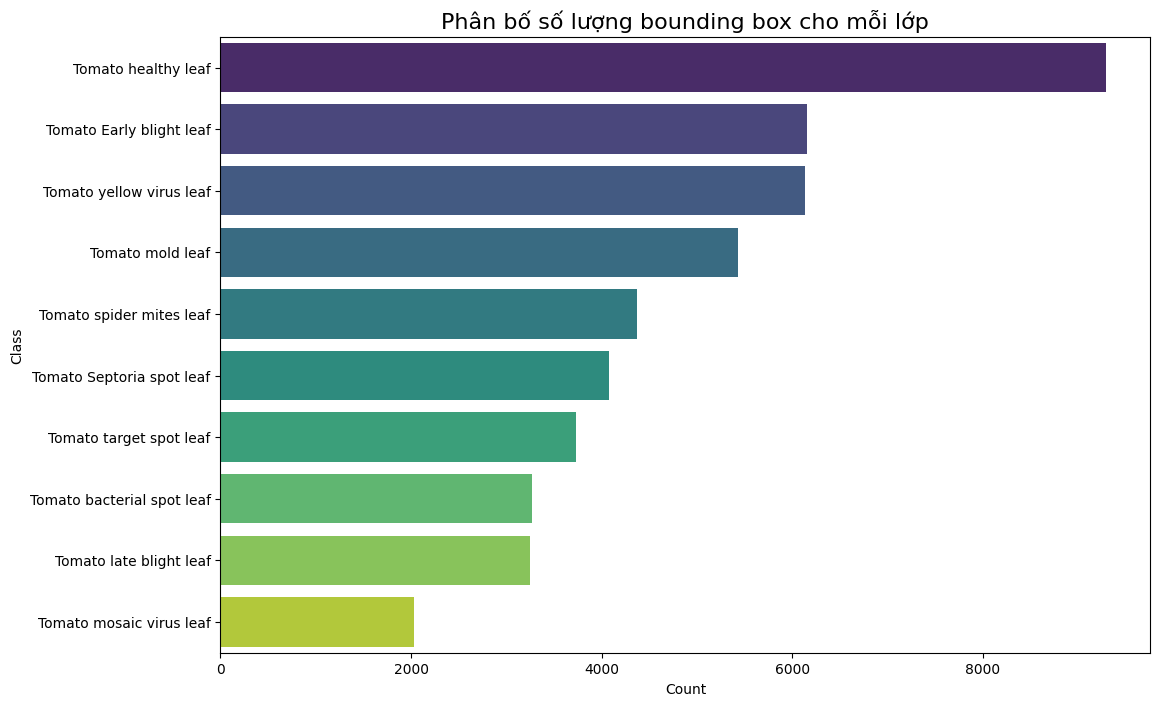

In [ ]:
# Tải dữ liệu từ Roboflow
try:
    rf = Roboflow(api_key="QMoCV2cQc0LpI3wVp89t")
    project = rf.workspace("timothy-mang-eni").project("diseases-2aogk")
    version = project.version(19)
    dataset = version.download("yolov8")
    DATASET_PATH = dataset.location
    YAML_PATH = os.path.join(DATASET_PATH, "data.yaml")
    print(f"Tải dữ liệu thành công, lưu tại: {DATASET_PATH}")
except Exception as e:
    print(f"Lỗi khi tải dữ liệu: {e}")

# Phân tích và trực quan hóa dữ liệu
def analyze_dataset(yaml_path, dataset_dir):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']
    
    label_counts = {name: 0 for name in class_names}
    for subset in ['train', 'valid', 'test']:
        label_path = os.path.join(dataset_dir, f'{subset}/labels')
        if os.path.exists(label_path):
            for label_file in os.listdir(label_path):
                with open(os.path.join(label_path, label_file), 'r') as lf:
                    for line in lf:
                        label_counts[class_names[int(line.split()[0])]] += 1
                        
    df_counts = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count']).sort_values('Count', ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis')
    plt.title('Phân bố số lượng bounding box cho mỗi lớp', fontsize=16)
    plt.show()

if 'YAML_PATH' in locals() and os.path.exists(YAML_PATH):
    analyze_dataset(YAML_PATH, DATASET_PATH)

In [ ]:
BEST_MODEL_PATH = None
TRAIN_RUN_PATH = None

# Cấu hình GPU
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = list(range(num_gpus))
    workers = 8 * num_gpus
    print(f"Sử dụng {num_gpus} GPU(s) để huấn luyện.")
else:
    device = 'cpu'
    workers = 1
    print("Sử dụng CPU để huấn luyện.")

# Tải mô hình Pretrained
model = YOLO('yolov8m.pt')

# Huấn luyện mô hình
try:
    results = model.train(
        data=YAML_PATH, 
        epochs=80, 
        patience=15, 

        batch=16, 
        imgsz=640,
        device=device, 
        workers=workers,
        optimizer='AdamW', 
        lr0=0.01, 
        cos_lr=True,
        # Augmentations
        mosaic=1.0, 
        mixup=0.2, 
        hsv_h=0.015, 
        hsv_s=0.7, 
        hsv_v=0.4,
        degrees=10.0, 
        translate=0.1, 
        scale=0.5, 
        shear=2.0,
        flipud=0.5, 
        fliplr=0.5,
        # Các thiết lập khác
        amp=True, 
        val=True, 
        exist_ok=True,
        verbose=True
    )
    
    print("Huấn luyện thành công!")
    TRAIN_RUN_PATH = model.trainer.save_dir
    BEST_MODEL_PATH = os.path.join(TRAIN_RUN_PATH, 'weights/best.pt')
    print(f"Mô hình tốt nhất được lưu tại: {BEST_MODEL_PATH}")

except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình huấn luyện: {e}")

Sử dụng 2 GPU(s) để huấn luyện.
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Diseases-19/data.yaml, degrees=10.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opse

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1521.7±423.9 MB/s, size: 56.5 KB)


train: Scanning /kaggle/working/Diseases-19/train/labels... 18129 images, 147 backgrounds, 0 corrupt: 100%|██████████| 18129/18129 [00:12<00:00, 1503.04it/s]


train: New cache created: /kaggle/working/Diseases-19/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 631, len(boxes) = 37227. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 515.8±489.2 MB/s, size: 52.2 KB)


val: Scanning /kaggle/working/Diseases-19/valid/labels... 3512 images, 12 backgrounds, 0 corrupt: 100%|██████████| 3512/3512 [00:02<00:00, 1389.82it/s]


val: New cache created: /kaggle/working/Diseases-19/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 84, len(boxes) = 7445. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      3.55G      1.485      2.736      1.961          4        640: 100%|██████████| 1134/1134 [06:11<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [03:26<00:00,  1.06it/s]


                   all       3512       7445      0.273      0.133     0.0803     0.0398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      4.23G      1.368      2.456      1.836          2        640: 100%|██████████| 1134/1134 [06:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:59<00:00,  3.69it/s]


                   all       3512       7445      0.298      0.334       0.23       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      4.29G      1.294      2.292      1.769          1        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:53<00:00,  4.14it/s]


                   all       3512       7445      0.346      0.373      0.329       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      4.34G      1.228      2.169      1.711         14        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:52<00:00,  4.20it/s]


                   all       3512       7445      0.593      0.394      0.395      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.41G      1.187      2.052      1.675          8        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.29it/s]


                   all       3512       7445      0.459      0.391      0.391      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      4.47G      1.149      1.964       1.64          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:52<00:00,  4.23it/s]


                   all       3512       7445      0.459      0.411      0.399      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.54G      1.117      1.904      1.608          8        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.27it/s]


                   all       3512       7445      0.601      0.435      0.494      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      4.85G      1.102      1.832      1.592          8        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.26it/s]


                   all       3512       7445      0.599      0.443      0.511      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      4.92G      1.067      1.756      1.566          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.29it/s]


                   all       3512       7445      0.615      0.467      0.517      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      4.98G      1.063       1.71      1.558          4        640: 100%|██████████| 1134/1134 [05:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.27it/s]


                   all       3512       7445      0.625      0.486       0.55      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      5.05G      1.041      1.673      1.547          1        640: 100%|██████████| 1134/1134 [05:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.26it/s]


                   all       3512       7445      0.741      0.496      0.601      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      5.52G      1.025      1.609      1.529          2        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.28it/s]


                   all       3512       7445      0.719      0.514      0.611      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      5.59G      1.012      1.586      1.522          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


                   all       3512       7445       0.69      0.547      0.622       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      5.65G      1.005      1.571      1.517          3        640: 100%|██████████| 1134/1134 [05:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


                   all       3512       7445      0.686      0.557      0.629      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      5.73G     0.9918      1.517      1.503          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


                   all       3512       7445       0.68      0.552      0.634      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      6.19G     0.9915      1.499      1.499          6        640: 100%|██████████| 1134/1134 [05:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


                   all       3512       7445      0.689      0.576      0.653      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      6.27G     0.9828      1.487      1.493         30        640: 100%|██████████| 1134/1134 [05:59<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


                   all       3512       7445       0.66      0.592      0.656      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      6.33G       0.97      1.442      1.479          1        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


                   all       3512       7445      0.706      0.591      0.676      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80       6.4G     0.9708      1.438      1.479          4        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.32it/s]


                   all       3512       7445      0.661      0.588      0.658      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      6.46G      0.936      1.375      1.454          3        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.33it/s]


                   all       3512       7445      0.689      0.569      0.657      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      6.54G      0.945      1.374       1.46          4        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.34it/s]


                   all       3512       7445      0.691      0.593      0.674      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      6.84G     0.9181      1.341       1.44          4        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445       0.68       0.57      0.652      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      6.91G     0.9264      1.333      1.444          3        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


                   all       3512       7445      0.752      0.537      0.651      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      6.97G      0.925      1.329      1.441          6        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


                   all       3512       7445      0.688      0.574      0.645      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      7.12G     0.9154      1.313      1.438          4        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445        0.7      0.529      0.566      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      7.26G     0.9082      1.285      1.428          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445      0.749      0.512      0.562      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80       7.4G     0.9086      1.286      1.424          2        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


                   all       3512       7445      0.731       0.52      0.568      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      4.52G     0.8859      1.258       1.41          7        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


                   all       3512       7445      0.652      0.557      0.571      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.52G     0.8887       1.25      1.409          1        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445      0.662      0.514      0.498      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      4.52G     0.8872       1.24      1.416          4        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


                   all       3512       7445      0.767      0.499      0.569      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      4.59G     0.8815      1.227      1.407          2        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.37it/s]


                   all       3512       7445      0.664      0.503      0.493      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      4.66G     0.8705      1.198      1.406          2        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445      0.421      0.561       0.36      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80       4.8G     0.8778      1.216        1.4          1        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


                   all       3512       7445      0.518      0.555      0.429      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      4.89G     0.8635      1.189      1.389          4        640: 100%|██████████| 1134/1134 [06:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.37it/s]


                   all       3512       7445      0.617      0.555      0.498      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.96G     0.8699      1.187      1.391         17        640: 100%|██████████| 1134/1134 [06:02<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


                   all       3512       7445      0.624      0.557      0.499      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      5.06G     0.8643      1.161      1.389          5        640: 100%|██████████| 1134/1134 [06:01<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:50<00:00,  4.35it/s]


                   all       3512       7445      0.626      0.524      0.477      0.396
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 21, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

36 epochs completed in 4.179 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 220/220 [00:51<00:00,  4.26it/s]


                   all       3512       7445      0.693      0.592      0.674      0.535
Tomato Early blight leaf        476        784      0.647      0.654      0.692      0.545
Tomato Septoria spot leaf        476        684      0.732      0.713      0.785      0.667
Tomato bacterial spot leaf        328        462      0.756      0.658      0.752      0.664
   Tomato healthy leaf        212       1465      0.467      0.407      0.422      0.242
Tomato late blight leaf        320        375      0.803      0.813      0.869      0.735
      Tomato mold leaf        515        885      0.806      0.711      0.787      0.612
Tomato mosaic virus leaf        250        353       0.62      0.669      0.719      0.583
Tomato spider mites leaf        481        784      0.832      0.594      0.737       0.62
Tomato target spot leaf        157        731      0.494       0.13      0.263      0.146
Tomato yellow virus leaf        371        922      0.772      0.574      0.718      0.534


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 10.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train
Huấn luyện thành công!
Mô hình tốt nhất được lưu tại: runs/detect/train/weights/best.pt


Đang đánh giá mô hình trên tập test...
Ultralytics 8.3.145 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1513.2±207.5 MB/s, size: 70.2 KB)


val: Scanning /kaggle/working/Diseases-19/test/labels... 1481 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1481/1481 [00:01<00:00, 1471.37it/s]


val: New cache created: /kaggle/working/Diseases-19/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 32, len(boxes) = 3064. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:44<00:00,  2.09it/s]


                   all       1481       3064      0.698      0.625      0.703      0.559
Tomato Early blight leaf        200        285      0.659      0.698      0.761      0.621
Tomato Septoria spot leaf        233        308      0.775      0.792      0.846      0.734
Tomato bacterial spot leaf        125        150       0.75      0.813      0.871       0.77
   Tomato healthy leaf         97        693      0.459      0.426      0.436      0.244
Tomato late blight leaf        109        158       0.73      0.703      0.752        0.6
      Tomato mold leaf        164        401      0.797      0.546      0.674      0.492
Tomato mosaic virus leaf        117        138      0.595      0.804      0.801      0.668
Tomato spider mites leaf        244        392       0.86      0.629      0.797      0.654
Tomato target spot leaf         72        260      0.545      0.196      0.347        0.2
Tomato yellow virus leaf        147        279      0.815      0.645      0.746      0.605


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 25.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
Kết quả mAP50-95: 0.5587958581074279
Kết quả mAP50: 0.703165906276852
Hiển thị các biểu đồ kết quả huấn luyện:


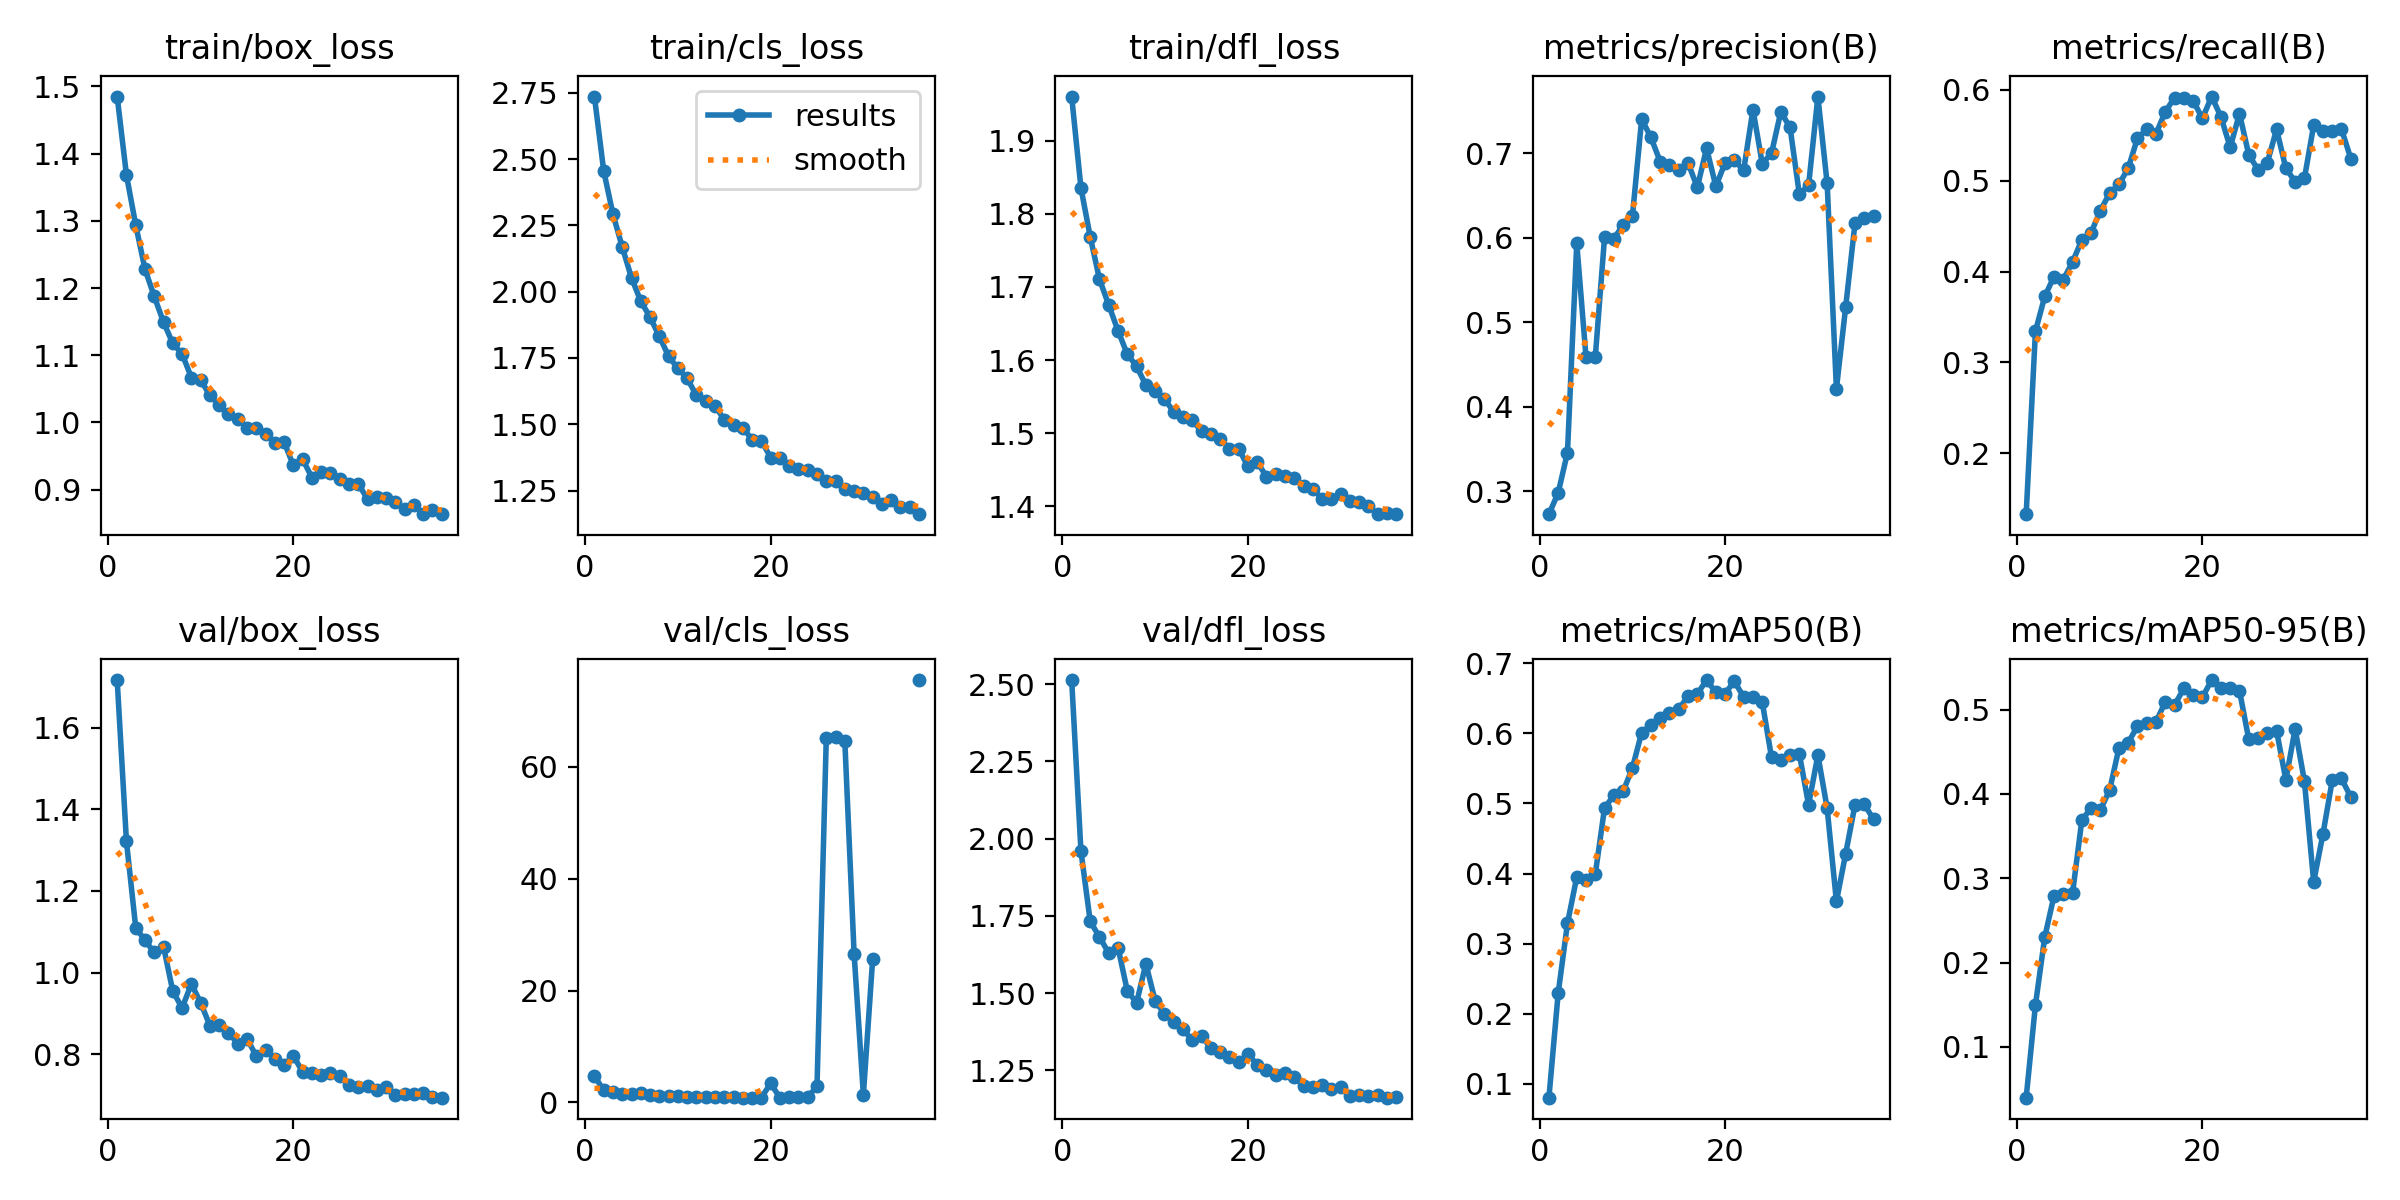

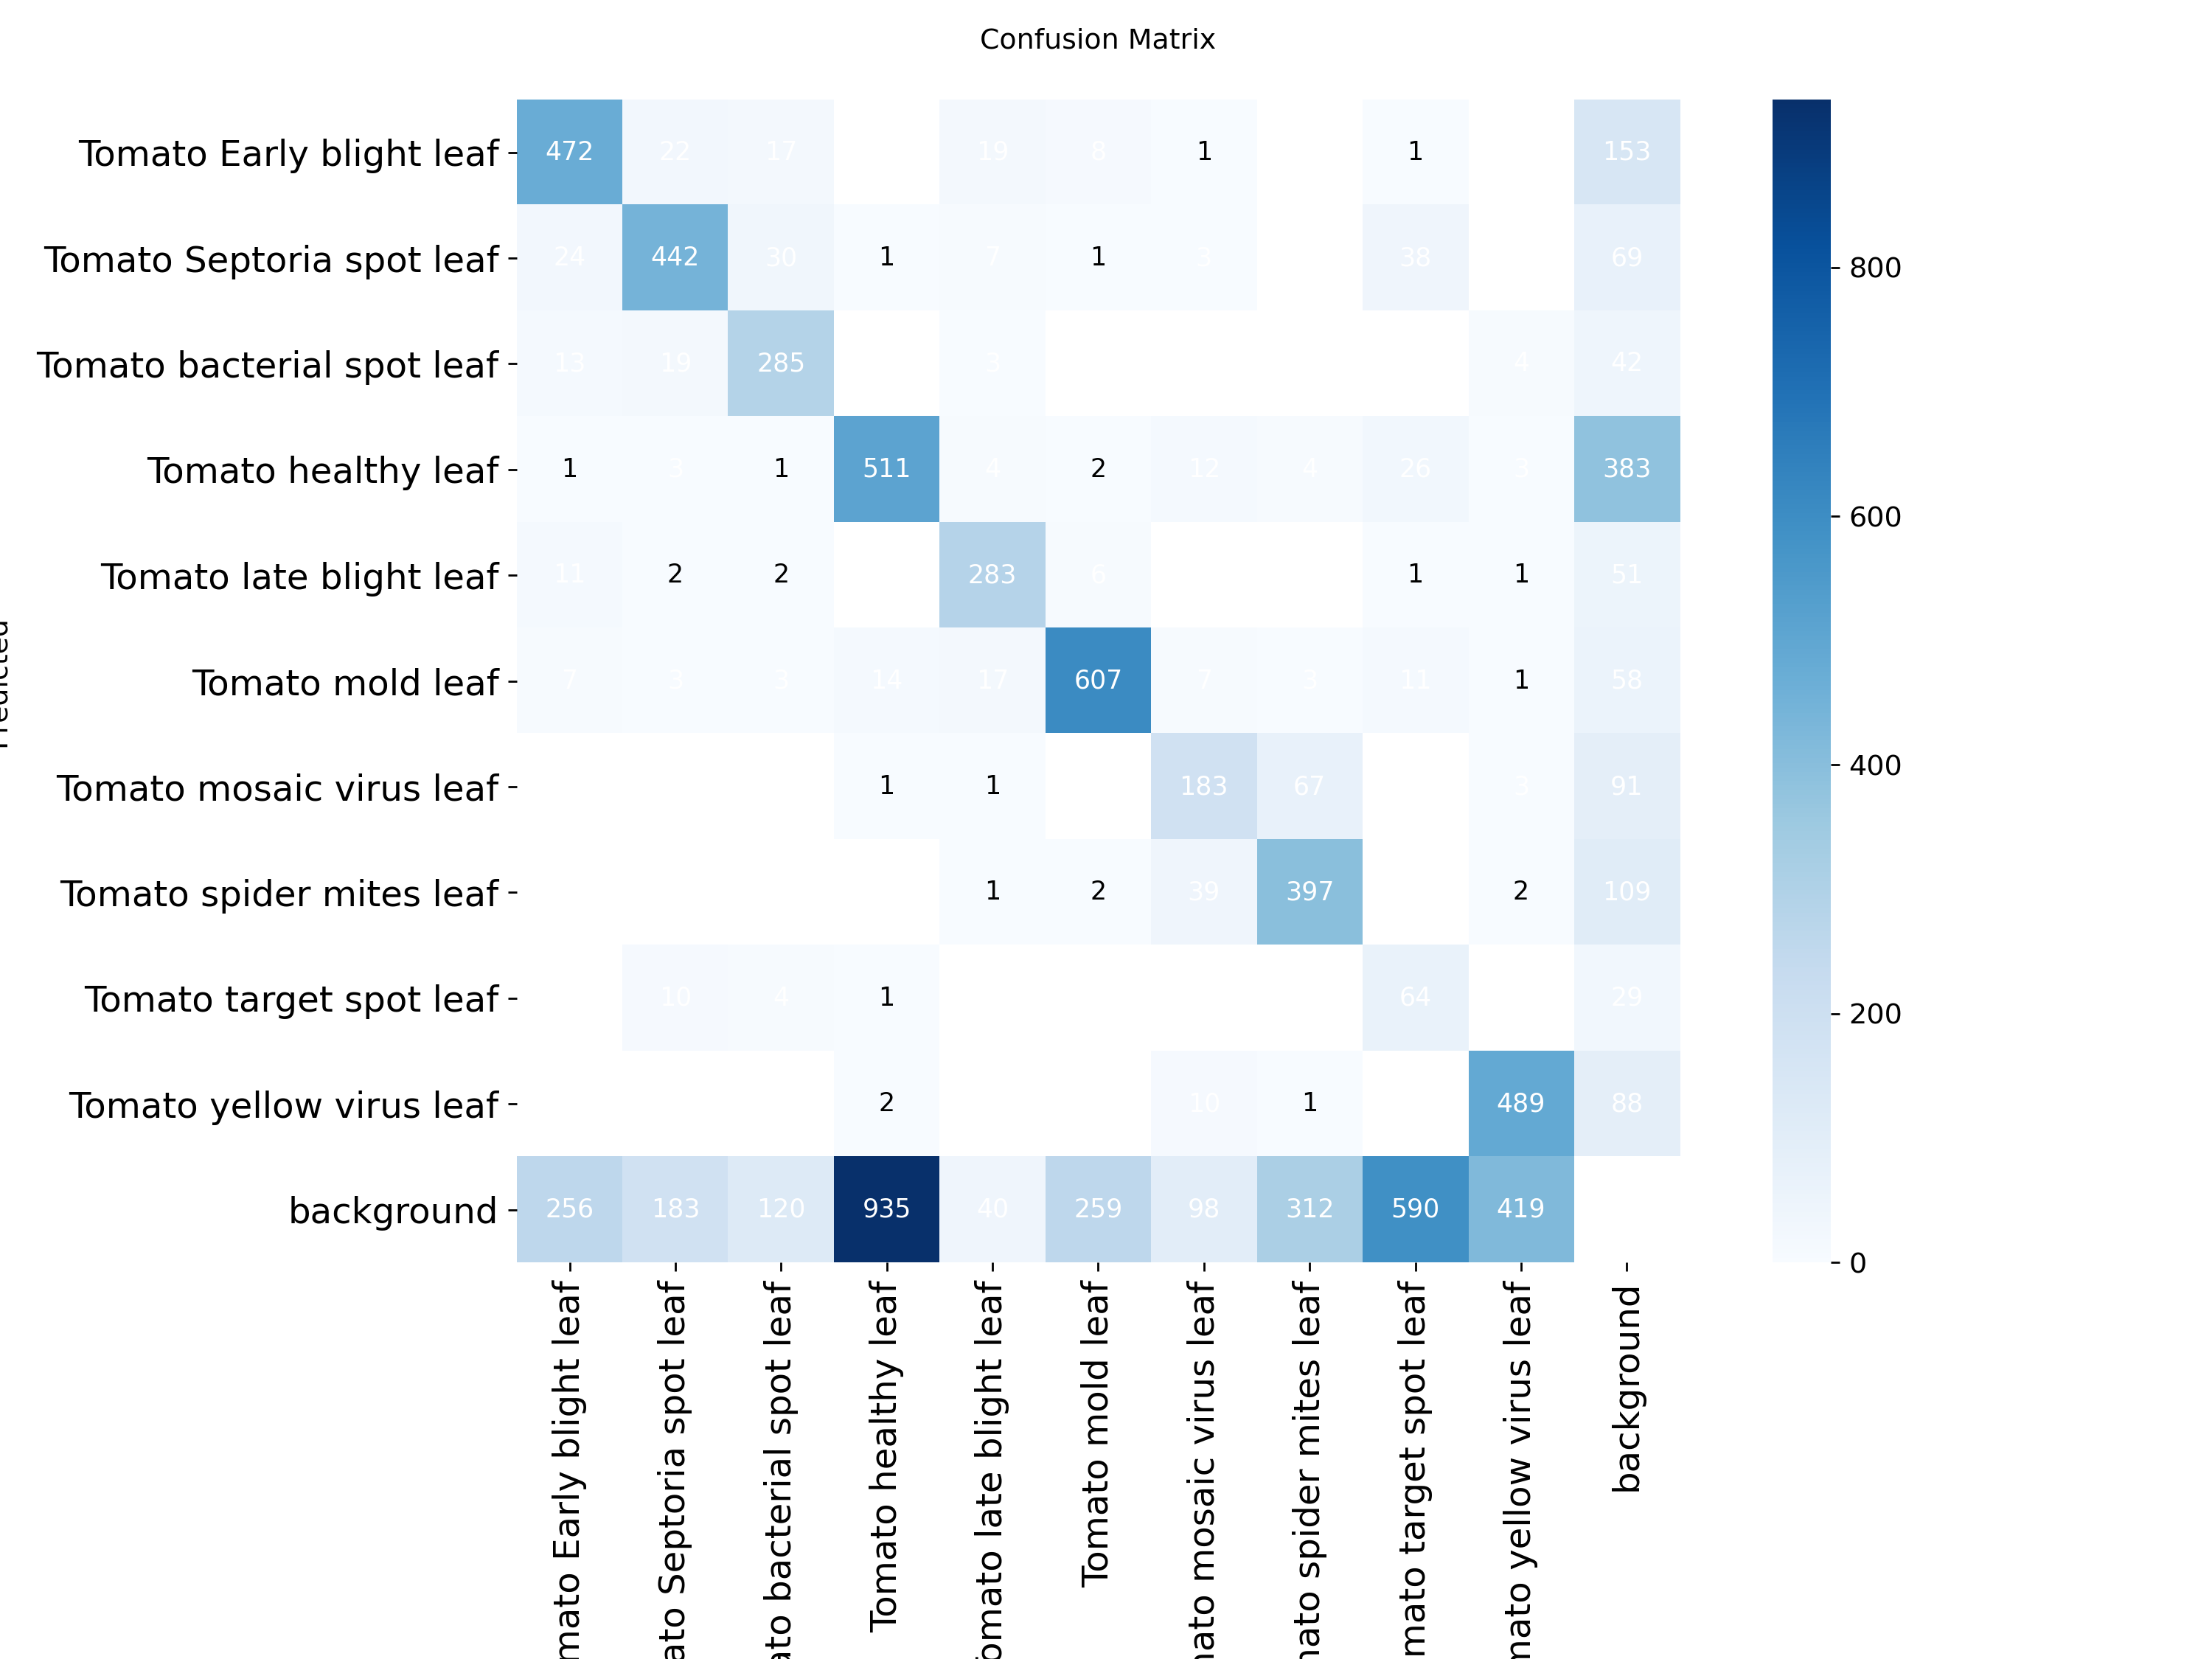

image 20/1481 /kaggle/working/Diseases-19/test/images/185427fc-b158-483e-8bbf-3579fc49c8dc___Com-G_SpM_FL-1428_JPG_jpg.rf.34220dae513e8f8a1a4afcbf0243894f.jpg: 640x640 1 Tomato spider mites leaf, 20.5ms
image 21/1481 /kaggle/working/Diseases-19/test/images/1b_jpg.rf.4c09510347b3142f6f09f298d32bfa3f.jpg: 640x640 1 Tomato bacterial spot leaf, 22.2ms
image 22/1481 /kaggle/working/Diseases-19/test/images/1ccfd473-6b3d-47a9-897b-0653d7683d75___PSU_CG-2163_JPG_jpg.rf.57cc051a3671703f9a32324e48c0f1ce.jpg: 640x640 1 Tomato spider mites leaf, 20.4ms
image 23/1481 /kaggle/working/Diseases-19/test/images/2015-09-17-01_jpg.rf.530eb31c537c160835afd4d0ba29e528.jpg: 640x640 2 Tomato healthy leafs, 21.8ms
image 24/1481 /kaggle/working/Diseases-19/test/images/2191359a-e985-4bf9-abe2-8f4e00685701___Com-G_SpM_FL-9645_JPG_jpg.rf.f45af4fad9767ea4b044393eb742185a.jpg: 640x640 1 Tomato spider mites leaf, 20.8ms
image 25/1481 /kaggle/working/Diseases-19/test/images/21f9a0a5-b145-40e7-8884-df2bb52eb592___RS_Er

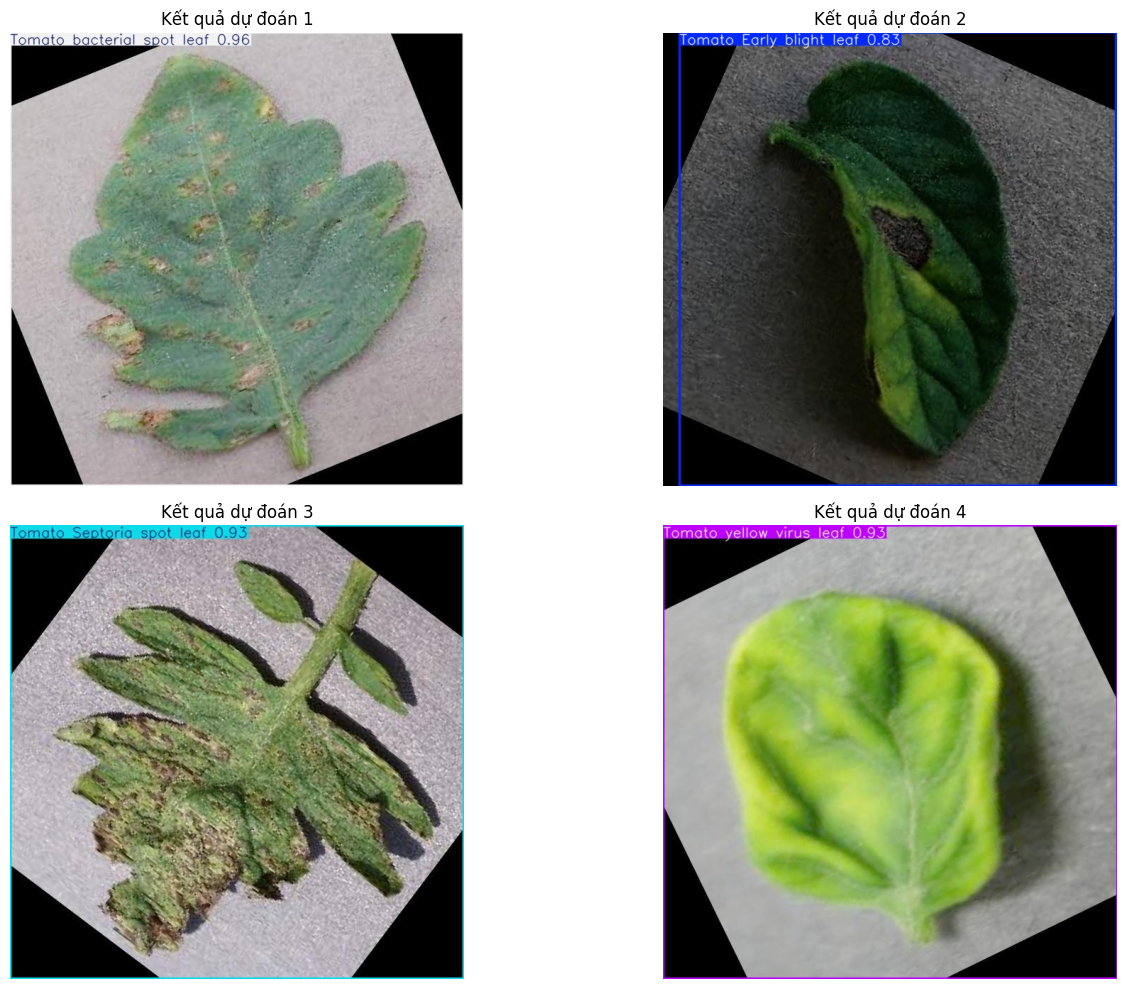

Hoàn tất.


In [ ]:

if 'BEST_MODEL_PATH' not in locals() or BEST_MODEL_PATH is None or not os.path.exists(BEST_MODEL_PATH):
    print("LỖI: Vui lòng chạy thành công ô Huấn luyện (CELL 3) trước khi chạy ô này.")
else:
    # Tải mô hình tốt nhất để đánh giá và dự đoán
    model = YOLO(BEST_MODEL_PATH)

    # 1. Đánh giá mô hình trên tập test
    print("Đang đánh giá mô hình trên tập test...")
    metrics = model.val(split='test')
    print("Kết quả mAP50-95:", metrics.box.map)
    print("Kết quả mAP50:", metrics.box.map50)

    # 2. Hiển thị các biểu đồ kết quả
    if 'TRAIN_RUN_PATH' in locals() and os.path.exists(TRAIN_RUN_PATH):
        print("Hiển thị các biểu đồ kết quả huấn luyện:")
        display(Image(filename=os.path.join(TRAIN_RUN_PATH, 'results.png'), width=800))
        display(Image(filename=os.path.join(TRAIN_RUN_PATH, 'confusion_matrix.png')))

    # 3. Dự đoán trên các ảnh test và hiển thị kết quả
    print("Đang chạy dự đoán trên một số ảnh test...")
    test_images_path = os.path.join(DATASET_PATH, 'test/images')
    results = model.predict(source=test_images_path, save=True, conf=0.4)
    
    print("Hiển thị một số kết quả dự đoán:")
    result_images = glob.glob(os.path.join(results[0].save_dir, '*.jpg'))[:4]
    if result_images:
        plt.figure(figsize=(15, 10))
        for i, img_path in enumerate(result_images):
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            plt.subplot(2, 2, i + 1)
            plt.imshow(image)
            plt.title(f"Kết quả dự đoán {i+1}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    print("Hoàn tất.")